In [1]:
# metadata:
# by Martin Okanik, 20/01/2023

import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, Activation, Conv1D, Flatten, Dropout, MaxPooling1D, BatchNormalization
from tensorflow.keras.models import Model
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

#==================================================================================================
# README:
# this script performs curriculum learning on levels [0,1,2,3,4] of the frequency signal of GWs

# DATA: this script (see below in the code) expects two numpy arrays at each level:
# X: shape = (events, channels, FT)
# y: shape = (events,)
# expected format and placement of these arrays:
# X = np.load(data_path+"X_FT_GData_{}.npy".format(level)), where level is in [0,1,2,3,4]
data_path = "FT_DATA/" #"from_dnobile/"
# data names depend on the level of curriculum learning, they are defined inside the main for loop

# MODEL: first defined in the code, then loaded and saved iteratively during curriculum learning
# define the name and path under which the cnn model is stored:
model_path = "curriculum_cnn2_GData10000_5epochs/"
model_name = "cnn2"
#os.mkdir(model_path)
#==================================================================================================


# CNN: define the cnn architecture and optimization strategy
# define the CNN
cnn = Sequential()
cnn.add(BatchNormalization())
# 1st conv. layer
cnn.add(Conv1D(filters=16, kernel_size=8, activation="relu"))
cnn.add(MaxPooling1D(pool_size=4, strides=4))
# 2nd conv. layer
cnn.add(Conv1D(filters=32, kernel_size=32, activation="relu"))
cnn.add(MaxPooling1D(pool_size=4, strides=4))
# 3rd conv. layer
cnn.add(Conv1D(filters=64, kernel_size=64, activation="relu"))
cnn.add(MaxPooling1D(pool_size=4, strides=4))
# 4th conv. layer
cnn.add(Conv1D(filters=128, kernel_size=128, activation="relu"))
cnn.add(MaxPooling1D(pool_size=4, strides=4))
# 5th conv. layer
#cnn.add(Conv1D(filters=256, kernel_size=256, activation="relu"))
#cnn.add(MaxPooling1D(pool_size=4, strides=4))
# change shape after the last conv. layer
cnn.add(Flatten())
# 1st dense layer
cnn.add(Dense(units=32, activation="relu"))
# final (output) dense layer
cnn.add(Dense(units=1, activation="sigmoid"))

# choose the optimizer
adamax = tf.keras.optimizers.Adamax(
    learning_rate=0.0001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07)
    #weight_decay=1e-6)
    
# compile the cnn
cnn.compile(loss='binary_crossentropy', 
              optimizer=adamax,  
              metrics=['accuracy'])





#=======================================================================================
# CURRICULUM LEARNING:

levels = [2] #,1,2,3,4] # each succesive is harder to train on

for level in levels:
    print("\n============================================================")
    print("Level", level)
    
    # unless we have just started (level==0), load cnn from the previous layer
    if level:
        cnn = keras.models.load_model("curriculum_cnn2_GData10000_5epochs_level1/" + model_name) 
    
    # load data from the current level
    X = np.load(data_path+"X_FT_GData_{}.npy".format(level)).astype("float16")
    y = np.load(data_path+"X_FT_GLabels_{}.npy".format(level)).astype("int")
    nrows, nchans, ncols = np.shape(X)
    nevents = nrows//2
    
    print("Shapes of X, y:")
    print(np.shape(X), np.shape(y))
    
    # augment the y array with labels in the second dimension
    ids = np.concatenate((np.arange(nevents), np.arange(nevents)), axis=None)
    y_and_ids = np.stack((y, ids)).T
    print("shape of y+IDs:\n", np.shape(y_and_ids))
    
    # perform train-test split
    #my_split = custom_split(X, y, test_size=0.2)
    X_train, X_test, y_and_ids_train, y_and_ids_test = train_test_split(X, y_and_ids, test_size=0.2, random_state = 42) #my_split[1:]#
    y_train = y_and_ids_train[:, 0]
    #ids_train = y_and_ids_train[:, 1]
    y_test = y_and_ids_test[:, 0]
    #ids_test = y_and_ids_test[:, 1]
    print("y_test:", y_test)
    print("y_train:", y_train)
    np.save(model_path + "/y_and_ids_test_{}.npy".format(level), y_and_ids_test)
    
    # exchange second and third dimension to comply with keras expected array shape ("channels last")
    X_train = np.swapaxes(X_train, 1, 2)
    X_test = np.swapaxes(X_test, 1, 2)
    print("Shapes of X_train, X_test, y_train, y_test:")
    print(np.shape(X_train), np.shape(X_test), np.shape(y_train), np.shape(y_test))
    
    # continue training the cnn on current data
    cnn.fit(X_train, y_train,
          batch_size=16,
          epochs=5,
          verbose=1,
          validation_split=0.25)
    
    # evaluate out-of-sample performance at this iteration
    score_cnn = cnn.evaluate(X_test, y_test, verbose=0)
    #print('Test loss:', score_cnn[0])
    print('Test accuracy at level {}: {:.3f}'.format(level, score_cnn[1]))
    print("==============================================================\n\n")
    
    # save model
    cnn.save(model_path + model_name)
     
# show the architecture
print("\n\n\n")
cnn.summary()


Level 2
Shapes of X, y:
(20000, 3, 29573) (20000,)
shape of y+IDs:
 (20000, 2)
y_test: [1 0 0 ... 0 0 1]
y_train: [0 0 0 ... 0 0 1]
Shapes of X_train, X_test, y_train, y_test:
(16000, 29573, 3) (4000, 29573, 3) (16000,) (4000,)
Epoch 1/5
750/750 [==============================] - 771s 1s/step - loss: 0.4222 - accuracy: 0.8002 - val_loss: 0.3959 - val_accuracy: 0.8170
Epoch 2/5
750/750 [==============================] - 682s 909ms/step - loss: 0.3892 - accuracy: 0.8248 - val_loss: 0.3956 - val_accuracy: 0.8173
Epoch 3/5
750/750 [==============================] - 788s 1s/step - loss: 0.3697 - accuracy: 0.8337 - val_loss: 0.3927 - val_accuracy: 0.8173
Epoch 4/5
750/750 [==============================] - 854s 1s/step - loss: 0.3464 - accuracy: 0.8493 - val_loss: 0.3918 - val_accuracy: 0.8127
Epoch 5/5
750/750 [==============================] - 846s 1s/step - loss: 0.3185 - accuracy: 0.8662 - val_loss: 0.3941 - val_accuracy: 0.8170
Test accuracy at level 2: 0.795


Instructions for updatin

In [3]:
nrows = 20000
print("nrows:", nrows)
print("y_test:\n", y_test)
indices_test = np.load("indices_test_0.npy")
print("\nindices_test:\n", indices_test )

# these functions retrieve the name of the corresponding csv file from the row index stored in indices_test_{level}.npy
# each of the three functions uses the previous ones, in the end only the last is to be called by the user
def isEvent(row_idx, nrows):
    return int(row_idx >= nrows//2)
def eventIdx(row_idx, nrows):
    return row_idx - nrows//2 * isEvent(row_idx, nrows)
def csv_from_rowIdx(indices_test, nrows):
    csvs = []
    for row_idx in indices_test:
         csvs.append("{}_{}".format(eventIdx(row_idx, nrows), isEvent(row_idx, nrows)))
    return csvs

print("\ncsv-files:\n", csv_from_rowIdx(indices_test, nrows=nrows))
    

nrows: 20000
y_test:
 [1 0 0 ... 0 0 1]

indices_test:
 [    1     2     3 ... 19993 19995 19996]

csv-files:
 ['1_0', '2_0', '3_0', '6_0', '11_0', '12_0', '14_0', '20_0', '21_0', '23_0', '24_0', '32_0', '37_0', '43_0', '46_0', '47_0', '66_0', '70_0', '71_0', '78_0', '80_0', '82_0', '86_0', '94_0', '96_0', '97_0', '98_0', '101_0', '104_0', '109_0', '115_0', '125_0', '131_0', '134_0', '135_0', '142_0', '155_0', '163_0', '167_0', '170_0', '175_0', '176_0', '178_0', '179_0', '186_0', '191_0', '200_0', '205_0', '208_0', '210_0', '215_0', '218_0', '219_0', '220_0', '221_0', '228_0', '238_0', '239_0', '241_0', '243_0', '245_0', '254_0', '275_0', '279_0', '280_0', '292_0', '293_0', '298_0', '301_0', '307_0', '312_0', '332_0', '345_0', '346_0', '354_0', '355_0', '359_0', '363_0', '364_0', '367_0', '368_0', '373_0', '374_0', '375_0', '378_0', '380_0', '389_0', '396_0', '407_0', '411_0', '414_0', '419_0', '422_0', '431_0', '452_0', '453_0', '456_0', '463_0', '466_0', '478_0', '481_0', '489_0', '

In [5]:
y_pred = cnn.predict(X_test).flatten()
y_pred_0 = y_pred[np.argwhere(y_test==0)]
y_pred_1 = y_pred[np.argwhere(y_test==1)]
#print(y_pred)#, "\n", y_pred_0, "\n", y_pred_1)

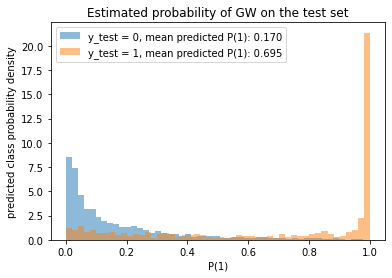

In [12]:
plt.hist(y_pred_0, alpha=0.5, bins=50, density=True, label="y_test = 0, mean predicted P(1): {:.3f}".format(np.mean(y_pred_0)))
plt.hist(y_pred_1, alpha=0.5, bins=50, density=True, label="y_test = 1, mean predicted P(1): {:.3f}".format(np.mean(y_pred_1)))
plt.legend()
plt.title("Estimated probability of GW on the test set")
plt.xlabel("P(1)")
plt.ylabel("predicted class probability density")
plt.savefig("curriculum_cnn2_GData10000_10epochs")
plt.show()

In [ ]:
print(y_train[:10])

In [ ]:
# try whether data matching by indices works as I think it does: (the two signals here should be the same)

X_001_0_H1 = np.load("FT_00000001_0_H1.npy")
plt.plot(X_001_0_H1, label="original dataset")
plt.plot(X_test[0, :, 0], label="test set") # 0th entry of y_test is row index 1, which translates to 001_0, and the channel index 0 means H1
plt.legend()
plt.title("Does event-channel-category matching by indices work?")
plt.savefig("test_index_matching.png")
plt.show()
# ...since the results overlap perfectly, my scheme should be working

In [2]:
import numpy as np
it = np.load("indices_test_0.npy")
print(it)

[    2    18    29 ... 19982 19989 19998]


In [ ]:
"""
#=======================================================================================
# TRAIN-TEST SPLIT:
# A custom function for train-test split that remembers and stores the test indices

def custom_split(X, y, test_size=0.2, seed=42):
    
    nrows, nchans, ncols = np.shape(X)
    
    indices = np.arange(nrows)
    indices_train = np.random.choice(indices, int(nrows*(1 - test_size)), replace=False) # int(nrows*0.75)
    indices_test = [idx for idx in indices if not(idx in indices_train)  ] 
    #print(indices_test)
    #print(indices_train)

    X_train = np.zeros((len(indices_train), nchans, ncols))
    y_train = np.zeros((len(indices_train)))
    X_test = np.zeros((len(indices_test), nchans, ncols))
    y_test = np.zeros((len(indices_test)))
    
    # event indices label the event based on the 8 digit code (they are the same for the three channels)
    # event indices combined with the indicator variable is_event = (0 or 1) provide a 1-to-1 mapping to csv files
    # there is twice as much rows as events, because of is_event can take 0 or 1 (noise or noise+signal)
    event_indices = np.arange(nrows)
    #rint("\nevent_indices:\n", event_indices)

    # repeat the same (consistent) pattern for all three channels:
    for channel_idx in range(nchans):
        # reset indices
        event_idx_train, event_idx_test = 0, 0
        for event_idx in event_indices:
            if event_idx in indices_train:
                X_train[event_idx_train, channel_idx, :] = X[event_idx, channel_idx, :]
                y_train[event_idx_train] = y[event_idx]
                event_idx_train += 1
            elif event_idx in indices_test:
                X_test[event_idx_test, channel_idx, :] = X[event_idx, channel_idx, :]
                y_test[event_idx_test] = y[event_idx]
                event_idx_test += 1
            else: 
                print("Error, unvalid index: ", event_idx)
                break

    # now the rows of original data array X are randomly shuffled into X_train and y_train, same for y
    # 0/1 of the same event can be both together or separated, it does not matter
    # however currently all 0's are in the first part of y_train and y_test, we want to keep this for y_test,
    # but shuffle y_train consistently with X_train, so that training is balanced (not first training on all
    # 0's and then training on all 1's)
    X_train, y_train = shuffle(X_train, y_train, random_state=seed)
    
    return indices_test, X_train, X_test, y_train, y_test
"""

In [7]:
import numpy as np

y = np.array([0,0,0,0,0,1,1,1,1,1])
ids = np.concatenate((np.arange(5), np.arange(5)), axis=None)

y_data = np.stack((y, ids))

print(y_data)
print(np.shape(y_data))
print(y_data[0, :])

[[0 0 0 0 0 1 1 1 1 1]
 [0 1 2 3 4 0 1 2 3 4]]
(2, 10)
[0 0 0 0 0 1 1 1 1 1]
